In [133]:
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import ipywidgets as widgets       # interactive display

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Network of LIFs

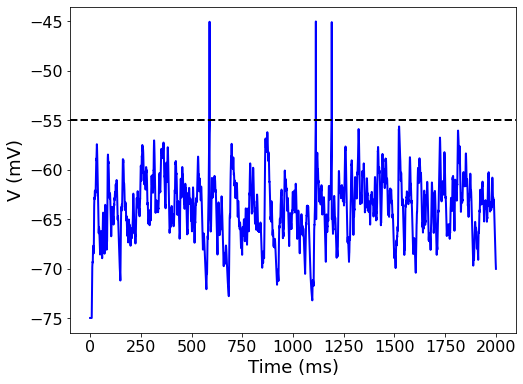

In [145]:
from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace

T, dt = 2e3, 0.1    # simulation period(ms), step size(ms)
wt, dl = 1., 5.
rt = 4e2

# simualtor
h = Simulator(dt=dt)

# neurons
nrn = LIF(sim=h)

# Poisson spike train inputs
Is = np.concatenate([np.zeros(int(T/dt/5)), rt*np.ones(int(T/dt/5*4))])
cur_in = Current_injector(sim=h, Is=Is)
exc_in = Poisson_generator(sim=h, rate=rt)  # rt: poisson spike train rate
inh_in = Poisson_generator(sim=h, rate=rt)

# connecting inputs to neurons
# nrn.connect(cur_in, {'ctype':'static', 'weight': wt, 'delay':dl})
# nrn.connect(exc_in, {'ctype':'static', 'weight': wt, 'delay':dl})
# nrn.connect(exc_in, {'ctype':'facilitate', 'weight': wt, 'delay':dl})
nrn.connect(exc_in, {'ctype':'depress', 'weight': wt, 'delay':dl})
# nrn.connect(inh_in, {'weight': -wt, 'delay':dl})

# simulate|
h.run(T)

# visualize
plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':-55.}
plot_volt_trace(plt_par, nrn.v, np.array(nrn.rec_spikes))

Text(0, 0.5, 'Idx')

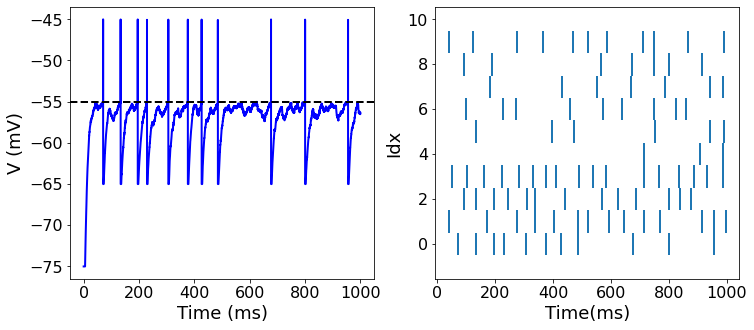

In [97]:
T, dt = 1e3, 0.1        # simulation period(ms), step size(ms)
N = 10                  # number of neurons
mean, std = 200., 40.   # background noise
wt, dl = 1., 5.

# simualtor
h = Simulator(dt=dt)

# network of neurons
nrns = [LIF(sim=h) for _ in range(N)]

# background noise
noises = [Gaussian_generator(sim=h, mean=mean, std=std) for _ in range(N)]
for noise, nrn in zip(noises, nrns):
    nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

# recurrent connections
p, w = 0.5, -1 # connection probability, connection strength
tps = [['facilitate']*N]*N
# tps = [['static']*N]*N
con = np.random.rand(N,N)*(np.random.rand(N,N)< p)*w
dly = np.random.uniform(2., 5., (N,N))
synspecs = [[{} for _ in range(N)] for _ in range(N)]
for i in range(N):
    for j in range(N):
        synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
h.connect(nrns, nrns, synspecs)  # random recurrent inhibition with probablity p, strength w and delay between 2 to 5 ms

# simulation
h.run(T)

# visualize
plt.subplots(1,2,figsize=(12,5))
plt.subplot(1,2,1)
plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':-55.}
plot_volt_trace(plt_par, nrns[0].v, np.array(nrns[0].rec_spikes))

# raster plots of population
spike_trains = [nrn.rec_spikes for nrn in nrns]
plt.subplot(1,2,2)
plt.eventplot(spike_trains);
plt.xlabel('Time(ms)')
plt.ylabel('Idx')